# Ensemble Learning Menggunakan SVM dan Naive Bayes

In [1]:
%pip install -q ucimlrepo scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Data Info

In [3]:
print("### 1. Tahap Pemahaman Data ###")

# Mengambil dataset
bank_marketing = fetch_ucirepo(id=222)
X_features = bank_marketing.data.features
y_target = bank_marketing.data.targets
df = pd.concat([X_features, y_target], axis=1)

# Menampilkan informasi dasar
print("\nInformasi Dataset:")
df.info()

### 1. Tahap Pemahaman Data ###

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Visualisasi Data

Cell ini didedikasikan untuk visualisasi guna memahami karakteristik data.

- **Distribusi Target**: Count Plot digunakan untuk melihat secara visual ketidakseimbangan antara kelas 'yes' dan 'no' pada variabel target.

- **Distribusi Fitur Numerik**: Histogram dibuat untuk beberapa fitur numerik kunci seperti `age`, `balance`, dan `duration` untuk melihat sebaran datanya. Visualisasi ini juga membantu mengidentifikasi skewness atau adanya outlier secara visual.

- **Distribusi Fitur Kategorikal**: Count Plot untuk fitur `job` digunakan untuk menunjukkan frekuensi setiap kategori pekerjaan. Plot ini membantu memahami komposisi demografis nasabah dalam dataset.

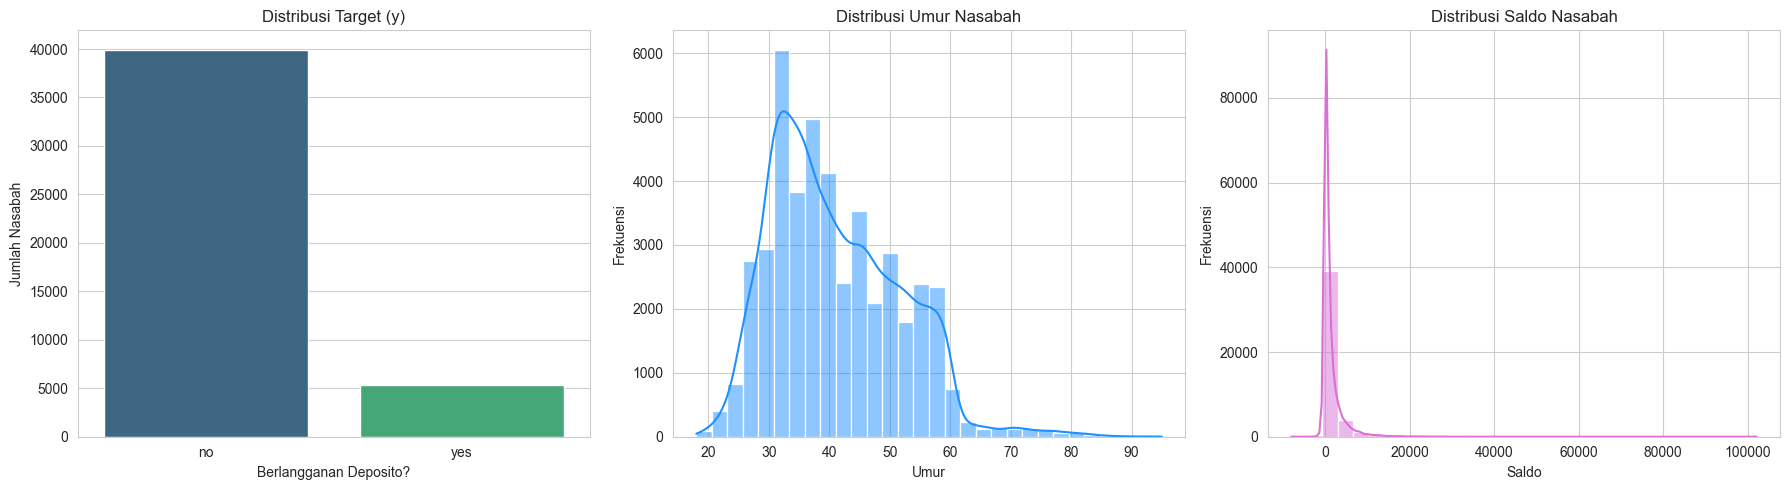

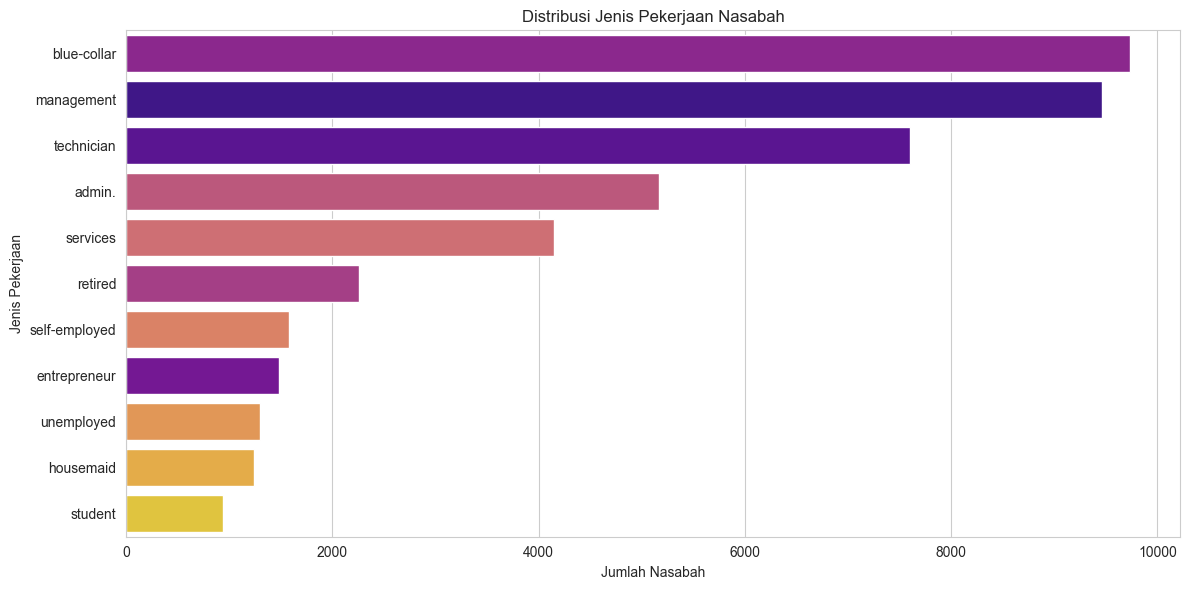

In [4]:
# Mengatur style plot
sns.set_style("whitegrid")
plt.figure(figsize=(18, 5))

# 1. Visualisasi Distribusi Target
plt.subplot(1, 3, 1)
sns.countplot(x='y', data=df, hue='y', palette='viridis')
plt.title('Distribusi Target (y)')
plt.xlabel('Berlangganan Deposito?')
plt.ylabel('Jumlah Nasabah')

# 2. Visualisasi Distribusi Umur (Age)
plt.subplot(1, 3, 2)
sns.histplot(df['age'], bins=30, kde=True, color='dodgerblue')
plt.title('Distribusi Umur Nasabah')
plt.xlabel('Umur')
plt.ylabel('Frekuensi')

# 3. Visualisasi Distribusi Saldo (Balance)
plt.subplot(1, 3, 3)
sns.histplot(df['balance'], bins=30, kde=True, color='orchid')
plt.title('Distribusi Saldo Nasabah')
plt.xlabel('Saldo')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

# Visualisasi untuk fitur kategorikal (contoh: 'job')
plt.figure(figsize=(12, 6))
sns.countplot(y='job', data=df, hue='job', order=df['job'].value_counts().index, palette='plasma', legend=False)
plt.title('Distribusi Jenis Pekerjaan Nasabah')
plt.xlabel('Jumlah Nasabah')
plt.ylabel('Jenis Pekerjaan')
plt.tight_layout()
plt.show()

## Data Preparation

Proses pada cell ini sama persis dengan sebelumnya, yaitu menangani outliers, nilai yang hilang, dan membagi data menjadi set latih dan uji

In [5]:
# Pisahkan Fitur (X) dan Target (y)
X = df.drop('y', axis=1)
y = df['y']

# Tangani Outliers pada fitur numerik
numeric_features = X.select_dtypes(include=np.number).columns
for col in numeric_features:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X[col] = np.clip(X[col], lower_bound, upper_bound)
print("Penanganan outliers selesai.")

# Identifikasi ulang fitur
categorical_features = X.select_dtypes(include=['object']).columns

# Buat pipeline preprocessing
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(
    strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(
    strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[(
    'num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(
    f"\nData dibagi menjadi {X_train.shape[0]} baris data latih dan {X_test.shape[0]} baris data uji.")

Penanganan outliers selesai.

Data dibagi menjadi 36168 baris data latih dan 9043 baris data uji.


## Modeling with Data Balancing

Proses pemodelan menggunakan `imblearn.pipeline` untuk menyatukan preprocessing, SMOTE, dan classifier juga tidak berubah.

In [6]:
# Pipeline untuk Bagging SVM dengan SMOTE
svm_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('sampler', SMOTE(
    random_state=42)), ('classifier', BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=42))])

# Pipeline untuk Bagging Naive Bayes dengan SMOTE
nb_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('sampler', SMOTE(random_state=42)), (
    'classifier', BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42))])

# Melatih model
print("Melatih model Bagging SVM dengan SMOTE...")
svm_pipeline.fit(X_train, y_train)
print("Melatih model Bagging Naive Bayes dengan SMOTE...")
nb_pipeline.fit(X_train, y_train)
print("\nPelatihan model selesai.")

Melatih model Bagging SVM dengan SMOTE...
Melatih model Bagging Naive Bayes dengan SMOTE...

Pelatihan model selesai.


### Hasil Evaluasi

Cell ini berisi evaluasi, yaitu menghitung akurasi dan mencetak classification report seperti sebelumnya

In [7]:
# Prediksi pada data uji
svm_preds = svm_pipeline.predict(X_test)
nb_preds = nb_pipeline.predict(X_test)

# Hitung akurasi
svm_accuracy = accuracy_score(y_test, svm_preds)
nb_accuracy = accuracy_score(y_test, nb_preds)

print("\n--- Hasil Perbandingan Akurasi ---")
print(f"Akurasi Bagging dengan SVM: {svm_accuracy:.4f}")
print(f"Akurasi Bagging dengan Naive Bayes: {nb_accuracy:.4f}")

print("\n--- Laporan Klasifikasi untuk Bagging SVM ---")
print(classification_report(y_test, svm_preds))

print("\n--- Laporan Klasifikasi untuk Bagging Naive Bayes ---")
print(classification_report(y_test, nb_preds))


--- Hasil Perbandingan Akurasi ---
Akurasi Bagging dengan SVM: 0.8643
Akurasi Bagging dengan Naive Bayes: 0.8296

--- Laporan Klasifikasi untuk Bagging SVM ---
              precision    recall  f1-score   support

          no       0.97      0.88      0.92      7985
         yes       0.45      0.78      0.57      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.83      0.75      9043
weighted avg       0.91      0.86      0.88      9043


--- Laporan Klasifikasi untuk Bagging Naive Bayes ---
              precision    recall  f1-score   support

          no       0.94      0.86      0.90      7985
         yes       0.36      0.59      0.45      1058

    accuracy                           0.83      9043
   macro avg       0.65      0.72      0.67      9043
weighted avg       0.87      0.83      0.85      9043



### Visualiasi Hasil Evaluasi

Cell baru ini menyajikan hasil evaluasi secara visual.

1. **Perbandingan Akurasi**
   
    Sebuah **bar plot sederhana** dibuat untuk membandingkan skor akurasi akhir dari kedua model. Visualisasi ini memberikan cara yang cepat dan jelas untuk melihat model mana yang memiliki performa lebih unggul.

2. **Confusion Matrix**
   
    **Confusion Matrix** divisualisasikan untuk model terbaik. Alat ini sangat berguna untuk menganalisis performa model secara lebih rinci, dengan menunjukkan jumlah prediksi yang benar (**True Positive**, **True Negative**) dan yang salah (**False Positive**, **False Negative**) untuk setiap kelas.

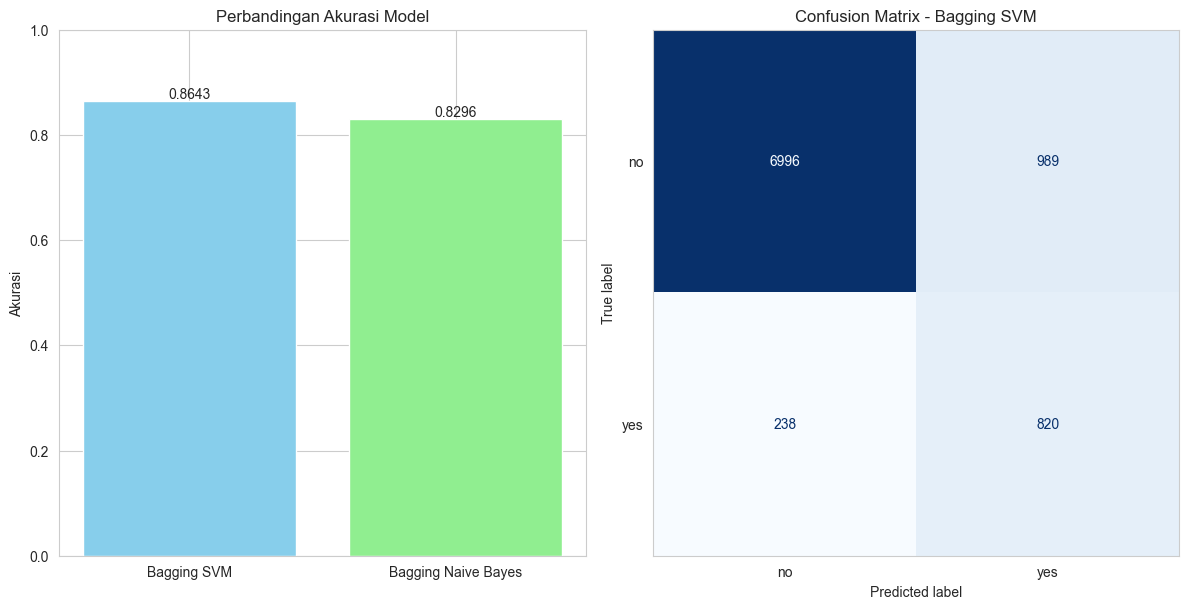


--- Kesimpulan ---
Berdasarkan akurasi dan visualisasi, estimator terbaik adalah Bagging dengan SVM.


In [8]:
# 1. Visualisasi Perbandingan Akurasi
model_scores = {'Bagging SVM': svm_accuracy,
                'Bagging Naive Bayes': nb_accuracy}
model_names = list(model_scores.keys())
accuracy_values = list(model_scores.values())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(model_names, accuracy_values, color=['skyblue', 'lightgreen'])
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval,
            f'{yval:.4f}', va='bottom', ha='center')  # va: vertical alignment

# 2. Visualisasi Confusion Matrix untuk model terbaik (SVM)
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, svm_preds, labels=svm_pipeline.classes_)
plt.subplot(1, 2, 2)
ax = plt.gca()  # get current axis
cm = confusion_matrix(y_test, svm_preds, labels=svm_pipeline.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=svm_pipeline.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=False)  # gambar di axis aktif
ax.grid(False)
plt.title('Confusion Matrix - Bagging SVM')

plt.title('Confusion Matrix - Bagging SVM')

plt.tight_layout()
plt.show()

# Kesimpulan
print("\n--- Kesimpulan ---")
if svm_accuracy > nb_accuracy:
    print("Berdasarkan akurasi dan visualisasi, estimator terbaik adalah Bagging dengan SVM.")
else:
    print("Berdasarkan akurasi dan visualisasi, estimator terbaik adalah Bagging dengan Naive Bayes.")